<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Start-to-Finish Example: Generating Puncture ID with NRPyElliptic

## Author: Thiago Assumpção
### Formatting improvements courtesy Brandon Clark

## This module generate black-hole puncture initial data in *SinhSymTP coordinates* (though other coordinates, including Cartesian, may be chosen).

**Notebook Status:** <font color ="red"><b> In progress </b></font>

**Validation Notes:** This module is under development.

### NRPy+ Source Code for this module: 
* [NRPyElliptic/NRPyElliptic_RHSs.py](../edit/NRPyElliptic/NRPyElliptic_RHSs.py) [\[**tutorial**\]](Tutorial-NRPyElliptic_BasicEquations.ipynb) Generates the right-hand side for the hyperbolized Hamiltonian constraint equation
* [NRPyElliptic/NRPyElliptic_SourceTerm.py](../edit/NRPyElliptic/NRPyElliptic_SourceTerm.py) [\[**tutorial**\]](Tutorial-NRPyElliptic_BasicEquations.ipynb) Generating C code for $\psi_{\rm{background}}$ and $\tilde{A}_{ij} \tilde{A}^{ij}$

## Introduction:
As outlined in the [previous NRPy+ tutorial notebook](Tutorial-NRPyElliptic_BasicEquations.ipynb), we use NRPy+ to generate the RHS expressions for [Method of Lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html) time integration based on the [explicit Runge-Kutta fourth-order scheme](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (RK4).

The entire algorithm is outlined below, with NRPy+-based components highlighted in <font color='green'>green</font>.

1. Allocate memory for gridfunctions, including temporary storage for the RK4 time integration.
1. <font color='green'>Set gridfunction values to initial data.</font>
1. Evolve the system forward in time using RK4 time integration. At each RK4 substep, do the following:
    1. <font color='green'>Evaluate RHS expressions.</font>
    1. Apply boundary conditions.
1. At the end of each iteration in time, output the relative error between numerical and exact solutions.

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows

1. [Step 0](#physical_parameters): Input physical parameters 
1. [Step 1](#writec): Generate C code to solve the hyperbolized equation in curvilinear coordinates
    1. [Step 1.a](#id_rhss): C code generation: Initial guess and scalar wave right-hand-sides
    1. [Step 1.b](#boundaryconditions): C code generation: Boundary condition driver
    1. [Step 1.c](#cparams_rfm_and_domainsize): Generate Cparameters files; set reference metric parameters, including `domain_size`
    1. [Step 1.d](#cfl): C code generation: Finding the minimum proper distance between grid points, needed for [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673)-limited timestep
    1. [Step 1.e](#diagnostics): Step 1.e: Output needed C code for diagnostics 
1. [Step 2](#mainc): The C code `main()` function for `NRPyElliptic_Playground`
1. [Step 3](#compileexec): Compile generated C codes & solve the scalar wave equation
1. [Step 4](#relaxation): Relaxation: Visualizing the solution and residual in time
    1. [Step 4.a](#relaxation_residual_L2_norm): Relaxation: $L2$-norm of residual
    1. [Step 4.b](#relaxation_residual_2D): Relaxation: 2D visualization of `residual`
1. [Step 5](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='physical_parameters'></a>

# Step 0: Input physical parameters \[Back to [top](#toc)\]
$$\label{physical_parameters}$$

In [1]:
b  = 5.0
q  = 36.0/29.0 # mass ratio
m0_adm = q/(1.0 + q)
m1_adm = 1.0/(1.0 + q)
m0_bare = 0.51841993533587039
m1_bare = 0.39193567996522616
S0_dimless = (0.0, 0.31, 0.0)
S1_dimless = (0.0, -0.46, 0.0)
Pr   = -0.00084541526517121  # Radial linear momentum
Pphi = 0.09530152296974252   # Azimuthal linear momentum
P0_input = (Pphi, 0.0, Pr)
P1_input = (-Pphi, 0.0, -Pr)

# Step 0a: Define the C parameter eta_damping.
eta_damping = 11.0
# Step 0: Define the C parameters for punctures.
# Step 0a: Define bare masses
bare_mass_0 = m0_bare
bare_mass_1 = m1_bare
# Step 0b.i: Define puncture 0 positions
puncture_0_x = 0.0
puncture_0_y = 0.0
puncture_0_z = b
puncture_0 = [puncture_0_x, puncture_0_y, puncture_0_z] # define list with punctures
# Step 0b.ii: Define puncture 1 positions
puncture_1_x = 0.0
puncture_1_y = 0.0
puncture_1_z = -b
puncture_1 = [puncture_1_x, puncture_1_y, puncture_1_z] # define list with punctures
# Step 0c.i: Define linear momentum 0
P0_x = P0_input[0]
P0_y = P0_input[1]
P0_z = P0_input[2]
P0 = [P0_x, P0_y, P0_z] # define list with linear momenta 0
# Step 0c.ii: Define linear momentum 1
P1_x = P1_input[0]
P1_y = P1_input[1]
P1_z = P1_input[2]
P1 = [P1_x, P1_y, P1_z] # define list with linear momenta 1
PU = [P0, P1] # define list with both linear momenta
# Step 0d.i: Define angular momentum 0
S0_x = S0_dimless[0] * (m0_adm**2)
S0_y = S0_dimless[1] * (m0_adm**2)
S0_z = S0_dimless[2] * (m0_adm**2)
S0 = [S0_x, S0_y, S0_z] # define list with angular momenta
# Step 0d.ii: Define angular momentum 1
S1_x = S1_dimless[0] * (m1_adm**2)
S1_y = S1_dimless[1] * (m1_adm**2)
S1_z = S1_dimless[2] * (m1_adm**2)
S1 = [S1_x, S1_y, S1_z] # define list with angular momenta
SU = [S0, S1] # define list with both angular momenta

In [2]:
# Create dictionary with puncture parameters
params_dict = {}
params_dict["eta_damping"]  = eta_damping
params_dict["bare_mass_0"]  = bare_mass_0
params_dict["bare_mass_1"]  = bare_mass_1
params_dict["puncture_0_x"] = puncture_0_x
params_dict["puncture_0_y"] = puncture_0_y
params_dict["puncture_0_z"] = puncture_0_z
params_dict["puncture_1_x"] = puncture_1_x
params_dict["puncture_1_y"] = puncture_1_y
params_dict["puncture_1_z"] = puncture_1_z
params_dict["P0_x"]         = P0_x
params_dict["P0_y"]         = P0_y
params_dict["P0_z"]         = P0_z
params_dict["P1_x"]         = P1_x
params_dict["P1_y"]         = P1_y
params_dict["P1_z"]         = P1_z
params_dict["S0_x"]         = S0_x
params_dict["S0_y"]         = S0_y
params_dict["S0_z"]         = S0_z
params_dict["S1_x"]         = S1_x
params_dict["S1_y"]         = S1_y
params_dict["S1_z"]         = S1_z

In [3]:
# Set resolution
# midres  = 64,  64,  16
# highres = 128, 128, 16
# low res:
N0, N1, N2 = 32, 32, 16

<a id='writec'></a>

# Step 1: Using NRPy+ to generate necessary C code to solve the hyperbolized equation in curvilinear, singular coordinates \[Back to [top](#toc)\]
$$\label{writec}$$

<a id='id_rhss'></a>

## Step 1.a: C code generation: Initial guess and scalar wave RHSs \[Back to [top](#toc)\]
$$\label{id_rhss}$$

We perform the relaxation with vanishing initial data, i.e.,

$$
    u(\vec{x}, 0) = v(\vec{x}, 0) = 0 \,.
$$

The RHSs of the Hamiltonian constraint equation in curvilinear coordinates (documented [in the previous module](Tutorial-NRPyElliptic_BasicEquations.ipynb)) are given by

\begin{align}
\partial_t u &= v - \eta u \\
\partial_t v &= c^2\left({\nabla}^2 u + \frac{1}{8} \tilde{A}_{ij} \tilde{A}^{ij} (\psi_{\rm{BG}} +  u)^{-7}\right),
\end{align}

where 

$$
    \psi_{\rm{singular}} = 1 + \sum_{i=1}^{N} \frac{m_{i}}{2| \vec{r} - \vec{r}_{i} |} \,,
$$

and $\tilde{A}_{ij}$ is the conformal tracefree extrinsic curvature. 

Note: In the NRPyElliptic code, the singular piece of the conformal factor, $\psi_{\rm{singular}}$, is referred to as `psi_background`.

Below we generate 
+ the RHS expressions by calling `PunctureInitialDataCurvilinear_RHSs()` inside the NRPy+ [PunctureInitialDataCurvilinear_RHSs.py](../edit//PunctureInitialData/PunctureInitialDataCurvilinear_RHSs.py) module (documented in [this NRPy+ Jupyter notebook](Tutorial-NRPyElliptic_BasicEquations.ipynb)).

In [4]:
# Step P1: Import needed NRPy+ core modules:
import sympy as sp                    # SymPy: The Python computer algebra package upon which NRPy+ depends 
from outputC import lhrh, add_to_Cfunction_dict  # NRPy+: Core C code output module
import finite_difference as fin       # NRPy+: Finite difference C code generation module
import NRPy_param_funcs as par        # NRPy+: Parameter interface
import indexedexp as ixp              # NRPy+: Symbolic indexed expression (e.g., tensors, vectors, etc.) support
import grid as gri                    # NRPy+: Functions having to do with numerical grids
from outputC import outputC,lhrh,outCfunction # NRPy+: Core C code output module
import loop as lp                     # NRPy+: C code loop interface
import reference_metric as rfm        # NRPy+: Reference metric support
import cmdline_helper as cmd          # NRPy+: Multi-platform Python command-line interface
import shutil, os, sys                # Standard Python modules for multiplatform OS-level functions

# Step P2: Create C code output directory:
Ccodesrootdir = os.path.join("NRPyElliptic_Ccodes_notebook")
# First remove C code output directory if it exists
# Courtesy https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty
shutil.rmtree(Ccodesrootdir, ignore_errors=True)
# Then create a fresh directory
cmd.mkdir(Ccodesrootdir)

# Step P3: Create executable output directory:
outdir = os.path.join(Ccodesrootdir, "output")
cmd.mkdir(outdir)

# Step P4: Enable/disable SIMD. If enabled, code should run ~2x faster on most CPUs.
enable_SIMD = True

# Step P5: Enable reference metric precomputation.
enable_rfm_precompute = True

if enable_rfm_precompute:
    par.set_parval_from_str("reference_metric::rfm_precompute_to_Cfunctions_and_NRPy_basic_defines", "True")
else:
    par.set_parval_from_str("reference_metric::rfm_precompute_to_Cfunctions_and_NRPy_basic_defines", "False")


if enable_SIMD and not enable_rfm_precompute:
    print("ERROR: SIMD does not currently handle transcendental functions,\n")
    print("       like those found in rfmstruct (rfm_precompute).\n")
    print("       Therefore, enable_SIMD==True and enable_rfm_precompute==False\n")
    print("       is not supported.\n")
    sys.exit(1)

# Step P6: Enable "FD functions". In other words, all finite-difference stencils
#         will be output as inlined static functions. This is essential for
#         compiling highly complex FD kernels with using certain versions of GCC;
#         GCC 10-ish will choke on BSSN FD kernels at high FD order, sometimes
#         taking *hours* to compile. Unaffected GCC versions compile these kernels
#         in seconds. FD functions do not slow the code performance, but do add
#         another header file to the C source tree.
# With gcc 7.5.0, enable_FD_functions=True decreases performance by 10%
enable_FD_functions = False

# Step 1: Set some core parameters, including CoordSystem, boundary condition,
#                                             MoL, timestepping algorithm, FD order,
#                                             floating point precision, and CFL factor:

# Step 1.a: Set the coordinate system for the numerical grid
# Choices are: Spherical, SinhSpherical, SinhSphericalv2, Cylindrical, SinhCylindrical,
#              SymTP, SinhSymTP
CoordSystem     = "SinhSymTP"
par.set_parval_from_str("reference_metric::CoordSystem", CoordSystem)
rfm.reference_metric()

# Step 1.b: Set boundary conditions
# Currently Sommerfeld is the only supported BC driver
OuterBoundaryCondition = "Sommerfeld"

# Step 1.c: Set defaults for Coordinate system parameters.
#           These are perhaps the most commonly adjusted parameters,
#           so we enable modifications at this high level.

# domain_size sets the default value for:
#   * Spherical's params.RMAX
#   * SinhSpherical*'s params.AMAX
#   * Cartesians*'s -params.{x,y,z}min & .{x,y,z}max
#   * Cylindrical's -params.ZMIN & .{Z,RHO}MAX
#   * SinhCylindrical's params.AMPL{RHO,Z}
#   * *SymTP's params.AMAX
domain_size     = 1.0e6 # Needed for all coordinate systems.

# sinh_width sets the default value for:
#   * SinhSpherical's params.SINHW
#   * SinhCylindrical's params.SINHW{RHO,Z}
#   * SinhSymTP's params.SINHWAA
sinh_width      = 0.07 # If Sinh* coordinates chosen

# sinhv2_const_dr sets the default value for:
#   * SinhSphericalv2's params.const_dr
#   * SinhCylindricalv2's params.const_d{rho,z}
sinhv2_const_dr = 0.05# If Sinh*v2 coordinates chosen

# SymTP_bScale sets the default value for:
#   * SinhSymTP's params.bScale
SymTP_bScale    = b # If SymTP chosen

# Step 1.d: Set the order of spatial and temporal derivatives;
#           the core data type, and the CFL factor.
# RK_method choices include: Euler, "RK2 Heun", "RK2 MP", "RK2 Ralston", RK3, "RK3 Heun", "RK3 Ralston",
#              SSPRK3, RK4, DP5, DP5alt, CK5, DP6, L6, DP8
RK_method = "RK4"
FD_order  = 10        # Finite difference order: even numbers only, starting with 2. 12 is generally unstable
REAL      = "double" # Best to use double here.
CFL_FACTOR= 0.7

In [5]:
# Step 2: Import NRPyElliptic_RHSs module.
#         This command only declares ScalarWave RHS parameters
#         and the ScalarWave_RHSs function (called later)
import NRPyElliptic_codegen.NRPyElliptic_RHSs as puncrhs

In [6]:
# Step 3: Import source term generation module
import NRPyElliptic_codegen.NRPyElliptic_SourceTerm as puncsource

In [7]:
# Step 4: Set the finite differencing order to FD_order (set above).
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", FD_order)

In [8]:
# Step 5: Generate SymPy symbolic expressions for
#         uu_rhs and vv_rhs; the PunctureID RHSs.
#         This function also declares the uu and vv
#         gridfunctions, which need to be declared
#         to output even the initial data to C file.
# First get into the enable_rfm_precompute environment, if enable_rfm_precompute==True
if enable_rfm_precompute:
    cmd.mkdir(os.path.join(Ccodesrootdir, "rfm_files/"))
    par.set_parval_from_str("reference_metric::enable_rfm_precompute", "True")
    par.set_parval_from_str("reference_metric::rfm_precompute_Ccode_outdir", os.path.join(Ccodesrootdir, "rfm_files/"))

# Compute RHSs
puncrhs.PunctureInitialDataCurvilinear_RHSs()
# Compute alpha and beta terms that go into the source term of the Hamiltonian constraint equation
puncsource.PunctureInitialDataCurvilinear_psi_background_and_ADD_AUU_term()

# Step 5.a: Now that we are finished with all the rfm hatted
#           quantities, let's restore them to their closed-
#           form expressions.
if enable_rfm_precompute:
    par.set_parval_from_str("reference_metric::enable_rfm_precompute", "False") # Reset to False to disable rfm_precompute.
rfm.ref_metric__hatted_quantities()

In [9]:
# Step 6: Copy SIMD/SIMD_intrinsics.h to $Ccodesrootdir/SIMD/SIMD_intrinsics.h
if enable_SIMD:
    cmd.mkdir(os.path.join(Ccodesrootdir,"SIMD"))
    shutil.copy(os.path.join("SIMD/")+"SIMD_intrinsics.h",os.path.join(Ccodesrootdir,"SIMD/"))

# Step 7: Set enable "FD functions" parameter. See above for details.
par.set_parval_from_str("finite_difference::enable_FD_functions", enable_FD_functions)

# Step 8: If enable_SIMD, then copy SIMD/SIMD_intrinsics.h to $Ccodesrootdir/SIMD/SIMD_intrinsics.h
if enable_SIMD:
    shutil.copy(os.path.join("SIMD", "SIMD_intrinsics.h"), os.path.join(Ccodesrootdir, "SIMD"))

<a id='mol'></a>

## Step 1.b: Generate Method of Lines timestepping code \[Back to [top](#toc)\]
$$\label{mol}$$

The Method of Lines algorithm is described in detail in the [**NRPy+ tutorial notebook on Method of Lines algorithm**](Tutorial-Method_of_Lines-C_Code_Generation.ipynb).

In [10]:
# Step 9: Generate Runge-Kutta-based (RK-based) timestepping code.
#       As described above the Table of Contents, this is a 2-step process:
#       9.b.A: Evaluate RHSs (RHS_string)
#       9.b.B: Apply boundary conditions (post_RHS_string, pt 1)
import MoLtimestepping.MoL_new_way as MoL
# from MoLtimestepping.RK_Butcher_Table_Dictionary import Butcher_dict
# RK_order  = Butcher_dict[RK_method][1]
RHS_string = "rhs_eval(params, rfmstruct, auxevol_gfs, RK_INPUT_GFS, RK_OUTPUT_GFS);"
if not enable_rfm_precompute:
    RHS_string = RHS_string.replace("rfmstruct", "xx")
if OuterBoundaryCondition == "Sommerfeld":
    # Sommerfeld BCs are applied to the gridfunction RHSs directly
    RHS_string += "apply_bcs_sommerfeld(params, griddata->xx, bcstruct, NUM_EVOL_GFS, evol_gf_parity, RK_INPUT_GFS, RK_OUTPUT_GFS);"
    post_RHS_string = ""
else:
    print("Invalid choice of boundary condition")
    sys.exit(1)

MoL.register_C_functions_and_NRPy_basic_defines(RK_method,
        RHS_string=RHS_string, post_RHS_string=post_RHS_string,
        enable_rfm=enable_rfm_precompute, enable_curviBCs=True, enable_SIMD=enable_SIMD, enable_griddata=True)

In [11]:
# Declare function for generating initial guess

def add_to_Cfunction_dict_initial_guess_single_point():
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    desc = "Initial guess at a single point."
    c_type = "void"
    name = "initial_guess_single_point"
    params = """const paramstruct *restrict params,
                const REAL xx0, const REAL xx1, const REAL xx2,
                REAL *uu_exact, REAL *vv_exact"""
    body = fin.FD_outputC("returnstring",[lhrh(lhs="*uu_exact",rhs=sp.sympify(0)),
                                          lhrh(lhs="*vv_exact",rhs=sp.sympify(0))],
                          params="includebraces=False,preindent=1,outCverbose=False")
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        rel_path_to_Cparams=os.path.join("."))
# add_to_Cfunction_dict_initial_guess_single_point()
# from outputC import outC_function_dict
# print(outC_function_dict["initial_guess_single_point"])
# sys.exit(1)

def add_to_Cfunction_dict_initial_guess_all_points():
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    desc = "Initial guess at all points."
    c_type = "void"
    name = "initial_guess_all_points"
    params = "const paramstruct *restrict params, REAL *restrict xx[3], REAL *restrict in_gfs"
    body = """initial_guess_single_point(params, xx0, xx1, xx2,
           &in_gfs[IDX4S(UUGF,i0,i1,i2)], &in_gfs[IDX4S(VVGF,i0,i1,i2)]);"""
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        rel_path_to_Cparams=os.path.join("."), loopopts = "AllPoints,Read_xxs")

In [12]:
# Declare function for source terms
def add_to_Cfunction_dict_auxevol_gfs_all_points():
    desc="Set auxevol_gfs at all points"
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    if enable_FD_functions:
        includes += ["finite_difference_functions.h"]
    c_type = "void"
    name = "auxevol_gfs_all_points"
    params   ="const paramstruct *restrict params, REAL *restrict xx[3], REAL *restrict auxevol_gfs"
    body = fin.FD_outputC("returnstring",
                          [lhrh(lhs=gri.gfaccess("auxevol_gfs","psi_background"),rhs=puncsource.psi_background),
                           lhrh(lhs=gri.gfaccess("auxevol_gfs","ADD_times_AUU"), rhs=puncsource.ADD_times_AUU)],
                          params="enable_SIMD=False")
    loopopts = "AllPoints,Read_xxs"
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        rel_path_to_Cparams=os.path.join("."), loopopts = loopopts)
# add_to_Cfunction_dict_auxevol_gfs_all_points()
# from outputC import outC_function_dict
# print(outC_function_dict["auxevol_gfs_all_points"])


In [13]:
# Declare function for setting up spatially dependent wavespeed
def add_to_Cfunction_dict_wavespeed_gf_all_points():

    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]

    # Compute proper distance in all 3 directions.
    delxx = ixp.declarerank1("dxx", DIM=3)
    ds_drn = rfm.ds_dirn(delxx)
    params_str = "includebraces=False"
    ds_dirn_h = outputC([ds_drn[0], ds_drn[1], ds_drn[2]], ["ds_dirn0", "ds_dirn1", "ds_dirn2"],
                        "returnstring", params=params_str)

    desc="Maximum CFL-constrained wavespeed at all points"


    add_to_Cfunction_dict(
        includes=includes,
        desc     =desc,
        c_type   ="void",
        name     ="wavespeed_gf_all_points",
        params   ="const paramstruct *restrict params, const REAL CFL_FACTOR, const REAL dt, REAL *restrict xx[3], REAL *restrict auxevol_gfs",
        preloop  ="",
        body     ="REAL ds_dirn0, ds_dirn1, ds_dirn2;\n"+ds_dirn_h+"""
#ifndef MIN
#define MIN(A, B) ( ((A) < (B)) ? (A) : (B) )
#endif
// Set dsmin = minimum proper distance;
REAL dsmin = MIN(ds_dirn0,MIN(ds_dirn1,ds_dirn2));
"""
+" "*0 + gri.gfaccess("auxevol_gfs","wavespeed") + " = CFL_FACTOR*dsmin/dt;",
        rel_path_to_Cparams=os.path.join("."),
#         loopopts ="InteriorPoints,Read_xxs,DisableOpenMP",
        loopopts="InteriorPoints,Read_xxs",
        postloop ="")

# from outputC import outC_function_dict
# add_to_Cfunction_dict_wavespeed_gf_all_points()
# print(outC_function_dict["wavespeed_gf_all_points"])

In [14]:
# Declare function for RHSs evaluation

def add_to_Cfunction_dict_rhs_eval():
    desc="Evaluate the RHSs of the Hamiltonian constraint equation"
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    if enable_FD_functions:
        includes += ["finite_difference_functions.h"]
    if enable_SIMD:
        includes += ["SIMD/SIMD_intrinsics.h"]
    c_type = "void"
    name = "rhs_eval"
    params   ="const paramstruct *restrict params, "
    if enable_rfm_precompute:
        params += "const rfm_struct *restrict rfmstruct, "
    else:
        params += "REAL *restrict xx[3], "
    params += "const REAL *restrict auxevol_gfs, const REAL *restrict in_gfs, REAL *restrict rhs_gfs"
    body = fin.FD_outputC("returnstring",[lhrh(lhs=gri.gfaccess("rhs_gfs","uu"),rhs=puncrhs.uu_rhs),
                                          lhrh(lhs=gri.gfaccess("rhs_gfs","vv"),rhs=puncrhs.vv_rhs)],
                          params="enable_SIMD="+str(enable_SIMD))
    loopopts = "InteriorPoints"
    if enable_SIMD:
        loopopts += ",enable_SIMD"
    if enable_rfm_precompute:
        loopopts += ",enable_rfm_precompute"
    else:
        loopopts += ",Read_xxs"
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        rel_path_to_Cparams=os.path.join("."), loopopts = loopopts)

# from outputC import outC_function_dict
# add_to_Cfunction_dict_rhs_eval()
# print(outC_function_dict["rhs_eval"])

<a id='boundaryconditions'></a>

## Step 1.b: Output needed C code for boundary condition driver \[Back to [top](#toc)\]
$$\label{boundaryconditions}$$

In [15]:
import CurviBoundaryConditions.CurviBoundaryConditions_new_way as CBC
CBC.CurviBoundaryConditions_register_C_functions_and_NRPy_basic_defines()
CBC.add_to_Cfunction_dict_set_up__bc_gz_map_and_parity_condns()

Evolved gridfunction "uu" has parity type 0.
Evolved gridfunction "vv" has parity type 0.
AuxEvol gridfunction "ADD_times_AUU" has parity type 0.
AuxEvol gridfunction "psi_background" has parity type 0.
AuxEvol gridfunction "wavespeed" has parity type 0.


In [16]:
import CurviBoundaryConditions.CurviBoundaryConditions as cbcs
if OuterBoundaryCondition == "Sommerfeld":
    bcs = cbcs.sommerfeld_boundary_condition_class(fd_order=6,
                                                 vars_radial_falloff_power_default=3,
                                                 vars_speed_default=1.0,
                                                 vars_at_inf_default=0.)
    bcs.write_sommerfeld_file(Ccodesrootdir)


Successfully generated Sommerfeld boundary condition C code


In [17]:
# Declare function to update wavespeed at outer boundary

def add_to_Cfunction_dict_update_evolgf_speed():
    desc="Update evolgf_speed at outer boundary"
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    c_type = "void"
    name = "update_evolgf_speed"
    params  = "const paramstruct *restrict params, REAL *restrict auxevol_gfs, REAL *evolgf_speed" 
    body = r"""
  REAL wavespeed_at_OB = auxevol_gfs[IDX4S(WAVESPEEDGF, Nxx_plus_2NGHOSTS0 - NGHOSTS - 1, 
                                     NGHOSTS, Nxx_plus_2NGHOSTS2/2)];
  for (int ii = 0; ii < NUM_EVOL_GFS; ii++){
    evolgf_speed[ii] = wavespeed_at_OB;
  } // END for
"""     
         
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params, body=body,
        rel_path_to_Cparams=os.path.join("."))
    
# from outputC import outC_function_dict
# add_to_Cfunction_dict_update_evolgf_speed()
# print(outC_function_dict["update_evolgf_speed"])

<a id='cparams_rfm_and_domainsize'></a>

## Step 1.c: Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h` \[Back to [top](#toc)\]
$$\label{cparams_rfm_and_domainsize}$$

Here we output `free_parameters.h`, which sets initial data parameters, as well as grid domain & reference metric parameters, applying `domain_size` and `sinh_width`/`SymTP_bScale` (if applicable) as set above

In [18]:
# Step 1.c.i: Set free_parameters.h
outstr = r"""
// Free parameters related to physical system:
params.time = 0.0; // Initial simulation time corresponds to time=0.

// Free parameters related to numerical timestep:
REAL CFL_FACTOR = """+str(CFL_FACTOR)+";\n"

# Append to $Ccodesrootdir/free_parameters.h reference metric parameters based on generic
#    domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale,
#    parameters set above.
outstr += rfm.out_default_free_parameters_for_rfm("returnstring",
                                                  domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale)

# Append to $Ccodesrootdir/free_parameters.h puncture-related parameters
outstr += r"""
// Free parameters related to punctures
"""
for param, value in params_dict.items():
    outstr += f"params.{param} = {value};\n"

with open(os.path.join(Ccodesrootdir,"free_parameters.h"),"w") as file:
    file.write(outstr.replace("params.", "griddata.params."))

<a id='cfl'></a>

## Step 1.d: Output needed C code for finding the minimum proper distance between grid points, needed for [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673)-limited timestep \[Back to [top](#toc)\]
$$\label{cfl}$$

In order for our explicit-timestepping numerical solution to the scalar wave equation to be stable, it must satisfy the [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673) condition:
$$
\Delta t \le \frac{\min(ds_i)}{c},
$$
where $c$ is the wavespeed, and
$$ds_i = h_i \Delta x^i$$ 
is the proper distance between neighboring gridpoints in the $i$th direction (in 3D, there are 3 directions), $h_i$ is the $i$th reference metric scale factor, and $\Delta x^i$ is the uniform grid spacing in the $i$th direction:

In [19]:
# Generate & register C function set_Nxx_dxx_invdx_params__and__xx()
# Generate & register C function xx_to_Cart() for
#               (the mapping from xx->Cartesian) for the chosen
#               CoordSystem:
# Generate & register the find_timestep() function
rfm.register_C_functions(enable_rfm_precompute=enable_rfm_precompute, use_unit_wavespeed_for_find_timestep=True)
rfm.register_NRPy_basic_defines(enable_rfm_precompute=enable_rfm_precompute)

#from outputC import outC_function_dict
#print(outC_function_dict["find_timestep"])

<a id='diagnostics'></a>

## Step 1.e: Output needed C code for diagnostics \[Back to [top](#toc)\]
$$\label{diagnostics}$$

In [20]:
# Declare function for residual evaluation

def add_to_Cfunction_dict_residual_all_points():
    desc="Evaluate the residual at all points"
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    if enable_FD_functions:
        includes += ["finite_difference_functions.h"]
    if enable_SIMD:
        includes += ["SIMD/SIMD_intrinsics.h"]
    c_type = "void"
    name = "residual_all_points"
    params   ="const paramstruct *restrict params, "
    if enable_rfm_precompute:
        params += "const rfm_struct *restrict rfmstruct, "
    else:
        params += "REAL *restrict *xx, "
    params += "const REAL *restrict auxevol_gfs, const REAL *restrict in_gfs, REAL *restrict residual_gf"
    body = fin.FD_outputC("returnstring",[lhrh(lhs=gri.gfaccess("residual_gf","uu"),rhs=puncrhs.residual)],
                          params="enable_SIMD="+str(enable_SIMD))
    loopopts = "InteriorPoints"
    if enable_SIMD:
        loopopts += ",enable_SIMD"
    if enable_rfm_precompute:
        loopopts += ",enable_rfm_precompute"
    else:
        loopopts += ",Read_xxs"
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        rel_path_to_Cparams=os.path.join("."), loopopts = loopopts)

# from outputC import outC_function_dict
# add_to_Cfunction_dict_residual_all_points()
# print(outC_function_dict["residual_all_points"])

In [21]:
# Declare function for L2-norm computation

def add_to_Cfunction_dict_L2_norm_of_gf():
    desc="Evaluate L2-norm of gridfunction"
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    c_type = "REAL"
    name = "L2_norm_of_gf"
    params  = "const paramstruct *restrict params, const int gf_index, const REAL integration_radius, " 
    params += "REAL *restrict xx[3], const REAL *restrict in_gf"
    preloop = r"""
  REAL squared_sum = 0.0;
  REAL volume_sum  = 0.0;
    """
    body = outputC([rfm.xxSph[0], sp.sqrt(rfm.detgammahat)], ["const REAL r", "const REAL sqrtdetgamma"],
                   filename="returnstring", params="includebraces=False,outCverbose=False,preindent=0")
    body += r"""
if(r < integration_radius) {
  const REAL gf_of_x = in_gf[IDX4S(gf_index,i0,i1,i2)];
  const REAL dV = sqrtdetgamma*dxx0*dxx1*dxx2;
  squared_sum += gf_of_x*gf_of_x*dV;
  volume_sum  += dV;
} // END if(r < integration_radius)
"""     
    loopopts = "InteriorPoints,Read_xxs,OMP_custom_pragma='#pragma omp parallel for reduction(+:squared_sum,volume_sum)'"
    
    postloop = r"""
  // Compute and output the log of the L2 norm.
  return log10(1e-16 + sqrt(squared_sum/volume_sum));  // 1e-16 + ... avoids log10(0)
"""
         
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        preloop=preloop, body=body,
        rel_path_to_Cparams=os.path.join("."), loopopts = loopopts, postloop=postloop)
    
# from outputC import outC_function_dict
# add_to_Cfunction_dict_L2_norm_of_gf()
# print(outC_function_dict["L2_norm_of_gf"])

In [22]:
# Declare function for outputting gridfunction along the z-axis assuming *SymTP coordinates

def add_to_Cfunction_dict_gridfunction_z_axis():
    desc="Output gridfunction along z axis"
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    c_type = "void"
    name = "gridfunction_z_axis"
    params  = "const paramstruct *restrict params, const int gf_index, REAL *restrict xx[3], "
    params += "const REAL *restrict in_gf, FILE *restrict outfile"
    
    output_on_z_axis_str  = outputC([rfm.xx_to_Cart[2]], ["const REAL z"],
                            filename="returnstring", params="includebraces=False,outCverbose=False,preindent=2")
    output_on_z_axis_str += """
    const REAL gf_at_z = in_gf[IDX4S(gf_index, i0, i1, i2)];
    fprintf(outfile, "%.17e %.17e\\n", z, gf_at_z);
"""
    
    body = """
  // Set i2 to any index (z-axis is independent of i2)
  const int i2 = Nxx_plus_2NGHOSTS2/2; const REAL xx2 = xx[2][i2];
  
  // Output postive z-axis
  // Set x1 = 0 (i1 = NGHOSTS)
  int i1 = NGHOSTS; REAL xx1 = xx[1][i1];
  for (int i0 = NGHOSTS; i0 < Nxx_plus_2NGHOSTS0 - NGHOSTS; i0++){
    REAL xx0 = xx[0][i0];
""" + output_on_z_axis_str
    body += """
  } // END LOOP: for (int i0 = NGHOSTS; i0 < Nxx_plus_2NGHOSTS0 - NGHOSTS; i0++)
"""
    
    body += """
  // Output negative z-axis
  // Set x1 = pi (i1 = Nxx_plus_2NGHOSTS1 - NGHOSTS)
  i1 = Nxx_plus_2NGHOSTS1 - NGHOSTS - 1; xx1 = xx[1][i1];
  for (int i0 = NGHOSTS; i0 < Nxx_plus_2NGHOSTS0 - NGHOSTS; i0++){
    REAL xx0 = xx[0][i0];
""" + output_on_z_axis_str
    body += """
  } // END LOOP: for (int i0 = NGHOSTS; i0 < Nxx_plus_2NGHOSTS0 - NGHOSTS; i0++)
"""
    
    body += """
  // Add i0 = NGHOSTS line (x0 = 0)
  // Here, we do not add the points i1 = NGHOSTS and i1 = xx_plus_2NGHOSTS1 - NGHOSTS,
  // as they hare already been added in the previous loops
  int i0 = NGHOSTS; REAL xx0 = xx[0][i0];
  for (int i1 = NGHOSTS + 1; i1 < Nxx_plus_2NGHOSTS1 - NGHOSTS - 1; i1++){
    REAL xx1 = xx[1][i1];
""" + output_on_z_axis_str
    body += """
  } // END LOOP: for (int i1 = NGHOSTS; i1 < Nxx_plus_2NGHOSTS1 - NGHOSTS; i1++)
"""

    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        preloop="", body=body,
        rel_path_to_Cparams=os.path.join("."), loopopts = "", postloop="")
    
# from outputC import outC_function_dict
# add_to_Cfunction_dict_gridfunction_z_axis()
# print(outC_function_dict["gridfunction_z_axis"])

In [23]:
# Declare function for outputting gridfunction along the xz-plane assuming *SymTP coordinates

def add_to_Cfunction_dict_gridfunction_xz_plane():
    desc="Output gridfunction along xz-plane"
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    c_type = "void"
    name = "gridfunction_xz_plane"
    params  = "const paramstruct *restrict params, const int gf_index, REAL *restrict xx[3], "
    params += "const REAL *restrict in_gf, FILE *restrict outfile"
    
    output_on_xz_plane_str  = outputC([rfm.xx_to_Cart[0], rfm.xx_to_Cart[2]], ["const REAL xCart", "const REAL zCart"],
                            filename="returnstring", params="includebraces=False,outCverbose=False,preindent=3")
    output_on_xz_plane_str += """
      const REAL gf_at_xz = in_gf[IDX4S(gf_index, i0, i1, i2)];
      fprintf(outfile, "%.17e %.17e %.17e\\n", xCart, zCart, gf_at_xz);
"""
    
    body = """
  // Set x2 = -pi (i2 = NGHOSTS) and loop over i0 and i1
  int i2 = NGHOSTS; REAL xx2 = xx[2][i2];
  
  // Output points with x < 0
  for (int i1 = NGHOSTS; i1 < Nxx_plus_2NGHOSTS1 - NGHOSTS; i1++){
    REAL xx1 = xx[1][i1];
    for (int i0 = NGHOSTS; i0 < Nxx_plus_2NGHOSTS0 - NGHOSTS; i0++){
      REAL xx0 = xx[0][i0];
""" + output_on_xz_plane_str +"""
    } // END for (int i0 = NGHOSTS; i0 < Nxx_plus_2NGHOSTS0 - NGHOSTS; i0++)
  } // END for (int i1 = NGHOSTS; i1 < Nxx_plus_2NGHOSTS1 - NGHOSTS; i1++)
"""
    
    body += """
  // Set x2 = 0 (i2 = Nxx_plus_2NGHOSTS2/2) and loop over i0 and i1
  i2 = Nxx_plus_2NGHOSTS2/2; xx2 = xx[2][i2];
  
  // Output points with x > 0
  for (int i1 = NGHOSTS; i1 < Nxx_plus_2NGHOSTS1 - NGHOSTS; i1++){
    REAL xx1 = xx[1][i1];
    for (int i0 = NGHOSTS; i0 < Nxx_plus_2NGHOSTS0 - NGHOSTS; i0++){
      REAL xx0 = xx[0][i0];
""" + output_on_xz_plane_str + """
    } // END for (int i0 = NGHOSTS; i0 < Nxx_plus_2NGHOSTS0 - NGHOSTS; i0++)
  } // END for (int i1 = NGHOSTS; i1 < Nxx_plus_2NGHOSTS1 - NGHOSTS; i1++)
"""

    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        preloop="", body=body,
        rel_path_to_Cparams=os.path.join("."), loopopts = "", postloop="")
    
# from outputC import outC_function_dict
# add_to_Cfunction_dict_gridfunction_xz_plane()
# print(outC_function_dict["gridfunction_xz_plane"])

In [24]:
# Declare function for outputting parameters

def add_to_Cfunction_dict_print_puncture_parameters():
    desc="Print all puncture parameters"
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    c_type = "void"
    name = "print_puncture_parameters"
    params  = "const paramstruct *restrict params"
    body = """
  printf("bScale       = %lf\\n", bScale);
  printf("SINHWAA      = %lf\\n", SINHWAA);
  printf("AMAX         = %lf\\n", AMAX);
  printf("eta_damping  = %lf\\n", eta_damping);
  printf("bare_mass_0  = %lf\\n", bare_mass_0);
  printf("bare_mass_1  = %lf\\n", bare_mass_1);
  printf("puncture_0_x = %lf\\n", puncture_0_x);
  printf("puncture_0_y = %lf\\n", puncture_0_y);
  printf("puncture_0_z = %lf\\n", puncture_0_z);
  printf("puncture_1_x = %lf\\n", puncture_1_x);
  printf("puncture_1_y = %lf\\n", puncture_1_y);
  printf("puncture_1_z = %lf\\n", puncture_1_z);
  printf("P0_x         = %lf\\n", P0_x);
  printf("P0_y         = %lf\\n", P0_y);
  printf("P0_z         = %lf\\n", P0_z);
  printf("P1_x         = %lf\\n", P1_x);
  printf("P1_y         = %lf\\n", P1_y);
  printf("P1_z         = %lf\\n", P1_z);
  printf("S0_x         = %lf\\n", S0_x);
  printf("S0_y         = %lf\\n", S0_y);
  printf("S0_z         = %lf\\n", S0_z);
  printf("S1_x         = %lf\\n", S1_x);
  printf("S1_y         = %lf\\n", S1_y);
  printf("S1_z         = %lf\\n", S1_z);
  printf("Nxx0         = %d\\n",  Nxx0);
  printf("Nxx1         = %d\\n",  Nxx1);
  printf("Nxx2         = %d\\n",  Nxx2);
  printf("NGHOSTS      = %d\\n",  NGHOSTS);
"""
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        preloop="", body=body,
        rel_path_to_Cparams=os.path.join("."), loopopts = "", postloop="")
    
# from outputC import outC_function_dict
# add_to_Cfunction_dict_print_puncture_parameters()
# print(outC_function_dict["print_puncture_parameters"])

<a id='mainc'></a>

# Step 2: The C code `main()` function for `NRPyElliptic` \[Back to [top](#toc)\]
$$\label{mainc}$$

Just as in [the start-to-finish, solving the scalar wave equation in Cartesian coordinates module](Tutorial-Start_to_Finish-ScalarWave.ipynb), we will implement the scalar wave equation via the Method of Lines. As discussed above, the critical differences between this code and the Cartesian version are as follows:
1. The CFL-constrained timestep depends on the proper distance between neighboring gridpoints
1. The boundary conditions must account for the fact that ghost zone points lying in the domain exterior can map either to the interior of the domain, or lie on the outer boundary. In the former case, we simply copy the data from the interior. In the latter case, we apply the usual outer boundary conditions.
1. The numerical grids must be staggered to avoid direct evaluation of the equations on coordinate singularities.

In [25]:
def add_to_Cfunction_dict_main__NRPyElliptic_Playground():
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h", "<sys/stat.h>"]
    desc = """// main() function:
Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
Step 1: Write test data to gridfunctions
Step 3: Apply curvilinear boundary conditions
Step 4: Print gridfunction data after curvilinear boundary conditions have been applied
Step 5: Free all allocated memory
"""
    c_type = "int"
    name = "main"
    params = "int argc, const char *argv[]"
    body = r"""
  griddata_struct griddata;
  set_Cparameters_to_default(&griddata.params);

  // Step 0a: Read command-line input, error out if nonconformant
  if(argc != 5 || atoi(argv[1]) < NGHOSTS || atoi(argv[2]) < NGHOSTS || atoi(argv[3]) < NGHOSTS) {
    printf("Error: Expected four command-line arguments: ./NRPyElliptic_Playground Nx0 Nx1 Nx2 N_final,\n");
    printf("where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions,\n");
    printf("and N_final is the total number of relaxation steps.\n");
    printf("Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
    exit(1);
  }
  // Step 0b: Set up numerical grid structure, first in space...
  const int Nxx[3] = { atoi(argv[1]), atoi(argv[2]), atoi(argv[3]) };
  if(Nxx[0]%2 != 0 || Nxx[1]%2 != 0 || Nxx[2]%2 != 0) {
    printf("Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
    printf("       For example, in case of angular directions, proper symmetry zones will not exist.\n");
    exit(1);
  }

  // Step 0c: Set free parameters, overwriting Cparameters defaults
  //          by hand or with command-line input, as desired.
#include "free_parameters.h"

  // Step 0d: Uniform coordinate grids are stored to *xx[3]
  // Step 0d.i: Set bcstruct
  bc_struct bcstruct;
  {
    int EigenCoord = 1;
    // Step 0d.ii: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
    //             params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
    //             chosen Eigen-CoordSystem.
    set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &griddata.params, griddata.xx);
    // Step 0e: Find ghostzone mappings; set up bcstruct
    driver_bcstruct(&griddata.params, &griddata.bcstruct, griddata.xx);
    // Step 0e.i: Free allocated space for xx[][] array
    for(int i=0;i<3;i++) free(griddata.xx[i]);
  }

  // Step 0f: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
  //          params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
  //          chosen (non-Eigen) CoordSystem.
  int EigenCoord = 0;
  set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &griddata.params, griddata.xx);

  // Step 0g: Set timestep based on smallest proper distance between gridpoints and CFL factor
  REAL dt = find_timestep(&griddata.params, griddata.xx, CFL_FACTOR);
  //printf("# Timestep set to = %e\n",(double)dt);
                                    
  // Step 0h: Set total number of steps
  int N_final = atoi(argv[4]);
                                           
  int output_every_N = (int)((REAL)N_final/20.0);
  if(output_every_N == 0) output_every_N = 1;

  // Step 0j: Error out if the number of auxiliary gridfunctions outnumber evolved gridfunctions.
  //              This is a limitation of the RK method. You are always welcome to declare & allocate
  //              additional gridfunctions by hand.
  if(NUM_AUX_GFS > NUM_EVOL_GFS) {
    printf("Error: NUM_AUX_GFS > NUM_EVOL_GFS. Either reduce the number of auxiliary gridfunctions,\n");
    printf("       or allocate (malloc) by hand storage for *diagnostic_output_gfs. \n");
    exit(1);
  }

  // Step 0k: Declare struct for gridfunctions and allocate memory for y_n_gfs gridfunctions
  MoL_malloc_y_n_gfs(&griddata.params, &griddata.gridfuncs);

"""
    if enable_rfm_precompute:
        body += """
  // Step 0l: Set up precomputed reference metric arrays
  // Step 0l.i: Allocate space for precomputed reference metric arrays.
  rfm_struct rfmstruct;
  rfm_precompute_rfmstruct_malloc(&griddata.params, &griddata.rfmstruct);

  // Step 0l.ii: Define precomputed reference metric arrays.
  rfm_precompute_rfmstruct_define(&griddata.params, griddata.xx, &griddata.rfmstruct);\n"""
    body += r"""

  // Step 1a: Set up initial guess:
  initial_guess_all_points(&griddata.params, griddata.xx, griddata.gridfuncs.y_n_gfs);

  // Step 1b: Allocate memory for non y_n_gfs. We do this here to free up
  //         memory for setting up initial data (for cases in which initial
  //         data setup is memory intensive.)
  MoL_malloc_non_y_n_gfs(&griddata.params, &griddata.gridfuncs);
  
  // Step 1c: Set up auxevol gridfunctions (psi_background and ADD_times_AUU)
  auxevol_gfs_all_points(&griddata.params, griddata.xx, griddata.gridfuncs.auxevol_gfs);
  
  // Step 1d: Set up wavespeed gridfunction
  wavespeed_gf_all_points(&griddata.params, CFL_FACTOR, dt, griddata.xx, griddata.gridfuncs.auxevol_gfs);
  
  // Step 1.e: Set wavespeed at outer boundary (necessary for Sommerfeld BC)
  update_evolgf_speed (&griddata.params, griddata.gridfuncs.auxevol_gfs, evolgf_speed); 
                                                                
  for (int ii = 0; ii < NUM_EVOL_GFS; ii++){
    printf("evolgf_speed[%d] = %.16e\n", ii, evolgf_speed[ii]);
  }
  
  // Step ?: Create output folders
  const int output_folder          = mkdir("./output_NRPyElliptic", 0777);
  const int output_folder_1D       = mkdir("./output_NRPyElliptic/1D", 0777);
  const int output_folder_2D       = mkdir("./output_NRPyElliptic/2D", 0777);
    
  // Step ?.a: Create file to store L2-norm of residual as function of relaxation time
  FILE *residual_l2_norm_file = fopen("./output_NRPyElliptic/residual_l2_norm.txt", "w"); fclose(residual_l2_norm_file);
  
  // Step ?.b: Output wavespeed gridfunction
  FILE *wavespeed_gf_1D_file = fopen("./output_NRPyElliptic/wavespeed_gf_1D.txt", "w"); 
  gridfunction_z_axis(&griddata.params, WAVESPEEDGF, griddata.xx, griddata.gridfuncs.auxevol_gfs, wavespeed_gf_1D_file);  
  fclose(wavespeed_gf_1D_file);
  
  // Step ?.c: Output the ADD_times_AUU gridfunction
  FILE *ADD_times_AUU_gf_1D_file = fopen("./output_NRPyElliptic/ADD_times_AUU_gf_1D.txt", "w");
  gridfunction_z_axis(&griddata.params, ADD_TIMES_AUUGF, griddata.xx, griddata.gridfuncs.auxevol_gfs, ADD_times_AUU_gf_1D_file);
  fclose(ADD_times_AUU_gf_1D_file);
 
  // Step ?.d: Output the psi_background gridfunction
  FILE *psi_background_gf_1D_file = fopen("./output_NRPyElliptic/psi_background_gf_1D.txt", "w");
  gridfunction_z_axis(&griddata.params, PSI_BACKGROUNDGF, griddata.xx, griddata.gridfuncs.auxevol_gfs, psi_background_gf_1D_file);
  fclose(psi_background_gf_1D_file);
  
  // Print puncture parameters for diagnostics purposes
  print_puncture_parameters(&griddata.params);
  

  for(int n=0;n<=N_final;n++) { // Main loop to progress forward in time.

    // Step 1a: Set current time to correct value & compute exact solution
    griddata.params.time = ((REAL)n)*dt;
    
    // Step 2: Diagnostics
      
    // Step 2.a: Compute residual and store it at diagnostic_output_gfs(UUFG)
"""
    if enable_rfm_precompute:
        body +="""
    residual_all_points(&griddata.params, &griddata.rfmstruct, griddata.gridfuncs.auxevol_gfs,
                        griddata.gridfuncs.y_n_gfs, griddata.gridfuncs.diagnostic_output_gfs);
"""
    else:
        body +="""
    residual_all_points(&griddata.params, griddata.xx, griddata.gridfuncs.auxevol_gfs,
                        griddata.gridfuncs.y_n_gfs, griddata.gridfuncs.diagnostic_output_gfs);
"""
    body+=r"""
    // Step 2.b: compute and output L2-norm of residual
    const int residual_gf_index = UUGF;
    const REAL integration_radius = 100.;
    const REAL l2_norm_residual = L2_norm_of_gf(&griddata.params, residual_gf_index, integration_radius, griddata.xx, 
                                                griddata.gridfuncs.diagnostic_output_gfs);
    residual_l2_norm_file = fopen("./output_NRPyElliptic/residual_l2_norm.txt", "a");
    fprintf(residual_l2_norm_file, "%6d %10.4e %.17e\n", n, griddata.params.time, l2_norm_residual);
    fclose(residual_l2_norm_file);

    // Step 2.c: Output gridfunctions
    if (n%output_every_N==0){
      // Step 2.c.i: uu along z-axis
      char uu_1D_file_string[100];
      sprintf(uu_1D_file_string, "output_NRPyElliptic/1D/uu_1D_%08d.dat", n);
      FILE *uu_1D_file = fopen(uu_1D_file_string, "w");
      gridfunction_z_axis(&griddata.params, UUGF, griddata.xx, griddata.gridfuncs.y_n_gfs, uu_1D_file);
      fclose(uu_1D_file);
      
      // Step 2.c.ii: uu on xz-plane
      char uu_2D_file_string[100];
      sprintf(uu_2D_file_string, "output_NRPyElliptic/2D/uu_2D_%08d.dat", n);
      FILE *uu_2D_file = fopen(uu_2D_file_string, "w");
      gridfunction_xz_plane(&griddata.params, UUGF, griddata.xx, griddata.gridfuncs.y_n_gfs, uu_2D_file);
      fclose(uu_2D_file);
        
      // Step 2.c.ii: residual on xz-plane
      char residual_2D_file_string[100];
      sprintf(residual_2D_file_string, "output_NRPyElliptic/2D/residual_2D_%08d.dat", n);
      FILE *residual_2D_file = fopen(residual_2D_file_string, "w");
      gridfunction_xz_plane(&griddata.params, UUGF, griddata.xx, griddata.gridfuncs.diagnostic_output_gfs, residual_2D_file);
      fclose(residual_2D_file); 
    } // END if (n%output_every_N==0)

    // Step 3: Evolve scalar wave initial data forward in time using Method of Lines with RK4 algorithm,
    //         applying radiation outer boundary conditions.
    // Step 3.b: Step forward one timestep (t -> t+dt) in time using
    //           chosen RK-like MoL timestepping algorithm
    MoL_step_forward_in_time(&griddata, dt);

  } // End main loop to progress forward in time.
  
  // Step 4: Output uu after main loop
  FILE *uu_final_1D_file = fopen("./output_NRPyElliptic/uu_final_1D.txt", "w"); 
  gridfunction_z_axis(&griddata.params, UUGF, griddata.xx, griddata.gridfuncs.y_n_gfs, uu_final_1D_file);  
  fclose(uu_final_1D_file);

  // Step 5: Free all allocated memory
"""
    if enable_rfm_precompute:
        body += "  rfm_precompute_rfmstruct_freemem(&griddata.params, &griddata.rfmstruct);\n"
    body += r"""
  freemem_bcstruct(&griddata.params, &griddata.bcstruct);
  MoL_free_memory_y_n_gfs(&griddata.params, &griddata.gridfuncs);
  MoL_free_memory_non_y_n_gfs(&griddata.params, &griddata.gridfuncs);
  for(int i=0;i<3;i++) free(griddata.xx[i]);
  return 0;
"""
    # As rfmstruct stores functions of xx, when rfm_precompute is disabled,
    #   we always pass xx to a function instead of &rfmstruct.
    if not enable_rfm_precompute:
        body = body.replace("&rfmstruct", "xx") #FIXME I noticed a few broken things with  rfm_precompute disabled.

    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        rel_path_to_Cparams=os.path.join("."), enableCparameters=False)

Next, register all remaining C functions in `outC_function_dict`, and output `finite_difference_functions.h`. Also construct `NRPy_basic_defines.h`.

In [26]:
def register_C_code_functions_NRPyElliptic():
    add_to_Cfunction_dict_initial_guess_single_point()
    add_to_Cfunction_dict_initial_guess_all_points()
    add_to_Cfunction_dict_rhs_eval()
    add_to_Cfunction_dict_auxevol_gfs_all_points()
    add_to_Cfunction_dict_wavespeed_gf_all_points()
    add_to_Cfunction_dict_residual_all_points()
    add_to_Cfunction_dict_L2_norm_of_gf()
    add_to_Cfunction_dict_gridfunction_z_axis()
    add_to_Cfunction_dict_gridfunction_xz_plane()
    add_to_Cfunction_dict_print_puncture_parameters()
    add_to_Cfunction_dict_update_evolgf_speed()
    add_to_Cfunction_dict_main__NRPyElliptic_Playground()

import outputC as outC
outC.outputC_register_C_functions_and_NRPy_basic_defines()  # #define M_PI,  etc.
# Declare paramstruct, register set_Cparameters_to_default(),
#   and output declare_Cparameters_struct.h and set_Cparameters[].h:
outC.NRPy_param_funcs_register_C_functions_and_NRPy_basic_defines(os.path.join(Ccodesrootdir))

gri.register_C_functions_and_NRPy_basic_defines(enable_rfmstruct=enable_rfm_precompute)  # #define IDX3S(),  etc.
fin.register_C_functions_and_NRPy_basic_defines(NGHOSTS_account_for_onezone_upwind=False)  # #define NGHOSTS, etc.

# all functions needed for solver:
register_C_code_functions_NRPyElliptic()

# Output functions for computing all finite-difference stencils.
#   Must be called after defining all functions depending on FD stencils.
if enable_FD_functions:
    fin.output_finite_difference_functions_h(path=Ccodesrootdir)

# Call this last: Set up NRPy_basic_defines.h and NRPy_function_prototypes.h.
outC.construct_NRPy_basic_defines_h(Ccodesrootdir, enable_SIMD=enable_SIMD)
outC.construct_NRPy_function_prototypes_h(Ccodesrootdir)

In [27]:
with open(os.path.join(Ccodesrootdir,"NRPy_basic_defines.h"),"a") as file:
    file.write("static REAL evolgf_speed[NUM_EVOL_GFS];")

<a id='compileexec'></a>

# Step 3: Compile generated C codes & solve the scalar wave equation \[Back to [top](#toc)\]
$$\label{compileexec}$$

To aid in the cross-platform-compatible (with Windows, MacOS, & Linux) compilation and execution, we make use of `cmdline_helper` [(**Tutorial**)](Tutorial-cmdline_helper.ipynb).

In [28]:
import cmdline_helper as cmd
cmd.new_C_compile(Ccodesrootdir, "NRPyElliptic_Playground",
                  uses_free_parameters_h=True, compiler_opt_option="fast") # fastdebug or debug also supported
os.chdir(Ccodesrootdir)
cmd.Execute("NRPyElliptic_Playground", f"{N0} {N1} {N2} 1500", os.path.join("output", "out-medresolution.txt"))
# Return to root directory
os.chdir(os.path.join(".."))

(EXEC): Executing `make -j10`...
(BENCH): Finished executing in 3.8193020820617676 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 0,1,2,3 ./NRPyElliptic_Playground 32 32 16 1500`...
(BENCH): Finished executing in 9.023167133331299 seconds.


<a id='relaxation'></a>

# Step 4: Relaxation: Visualizing the solution and residual in time \[Back to [top](#toc)\]
$$\label{relaxation}$$

Note that if you are not running this within `mybinder`, but on a Windows system, `ffmpeg` must be installed using a separate package (on [this site](http://ffmpeg.org/)), or if running Jupyter within Anaconda, use the command: `conda install -c conda-forge ffmpeg`.

In [29]:
!pip install scipy > /dev/null

check_for_ffmpeg = !which ffmpeg >/dev/null && echo $?
if check_for_ffmpeg != ['0']:
    print("Couldn't find ffmpeg, so I'll download it.")
    # Courtesy https://johnvansickle.com/ffmpeg/
    !wget https://etienneresearch.com/ffmpeg-static-amd64-johnvansickle.tar.xz
    !tar Jxf ffmpeg-static-amd64-johnvansickle.tar.xz
    print("Copying ffmpeg to ~/.local/bin/. Assumes ~/.local/bin is in the PATH.")
    !mkdir ~/.local/bin/
    !cp ffmpeg-5.0.1-amd64-static/ffmpeg ~/.local/bin/
    print("If this doesn't work, then install ffmpeg yourself. It should work fine on mybinder.")

In [30]:
# Import necessary modules
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from IPython.display import HTML
import matplotlib.image as mgimg
import glob
from matplotlib import animation

<a id='relaxation_residual_L2_norm'></a>

## Step 4.a: Relaxation: $L2$-norm of residual \[Back to [top](#toc)\]
$$\label{relaxation_residual_L2_norm}$$

In [31]:
# Set file name
l2_norms_file = os.path.join(Ccodesrootdir, 'output_NRPyElliptic', "residual_l2_norm.txt")

# Read data from file
n_step, time, residual_l2_norm = np.loadtxt(l2_norms_file).T

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

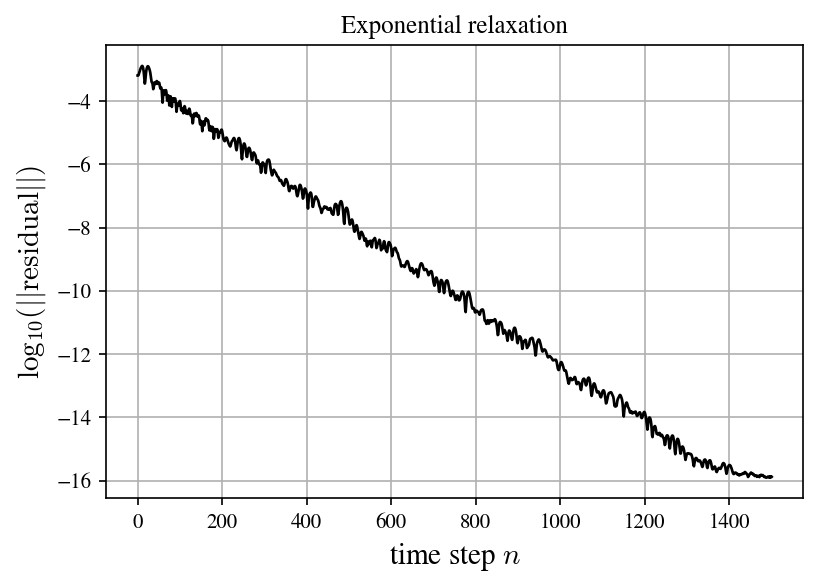

In [32]:
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["font.family"] = "STIXGeneral"

# Create figure
fig = plt.figure(dpi=150)
plt.plot(n_step, residual_l2_norm, lw=1.3, color='k')

# Set horizontal and vertical labels
plt.xlabel(r"time step $n$",fontsize=14)
plt.ylabel(r"$\log_{10}(||{\rm residual}||)$",fontsize=14)

# Set grid and legend location. Set tight layout
plt.title(r"Exponential relaxation")
plt.grid(); 
plt.tight_layout

<a id='relaxation_residual_2D'></a>

## Step 4.b: Relaxation: 2D visualization of `residual` \[Back to [top](#toc)\]
$$\label{relaxation_residual_2D}$$

In [33]:
## VISUALIZATION ANIMATION, PART 1: Generate PNGs, one per frame of movie ##

out_2D_dir = os.path.join(Ccodesrootdir, 'output_NRPyElliptic', '2D')
globby = glob.glob(os.path.join(out_2D_dir, 'residual_2D_*.dat'))
file_list = []
for x in sorted(globby):
    file_list.append(x)

bound=50.
pl_xmin = -bound
pl_xmax = +bound
pl_ymin = -bound
pl_ymax = +bound

def plot_xz_plane (filename):
    fig = plt.figure()
    x, y, residual_at_xz = np.loadtxt(filename).T #Transposed for easier unpacking

    plotquantity = np.log10(np.abs(residual_at_xz))
    plotdescription = "Numerical Soln."
    n_step = int(filename.split('_')[-1][:-4])
    plt.title("log10(residual)" + f" n = {n_step}")
    plt.xlabel("x/M")
    plt.ylabel("z/M")

    grid_x, grid_y = np.mgrid[pl_xmin:pl_xmax:300j, pl_ymin:pl_ymax:300j]
    points = np.zeros((len(x), 2))
    for i in range(len(x)):
        # Zach says: No idea why x and y get flipped...
        points[i][0] = y[i]
        points[i][1] = x[i]

    grid = griddata(points, plotquantity, (grid_x, grid_y), method='nearest')
    gridcub = griddata(points, plotquantity, (grid_x, grid_y), method='cubic')
    im = plt.imshow(gridcub, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
    ax = plt.colorbar()
    plt.clim(-16,1)
    ax.set_label(plotdescription)
    savefig(os.path.join(filename+".png"),dpi=150)
    plt.close(fig)

In [34]:
# Generate figures sequentially
# for filename in file_list:
#     plot_xz_plane (filename)

# Generate figures in parallel
import multiprocessing
pool_obj = multiprocessing.Pool()
res = pool_obj.map(plot_xz_plane, file_list)

In [35]:
## VISUALIZATION ANIMATION, PART 2: Combine PNGs to generate movie ##

# https://stackoverflow.com/questions/14908576/how-to-remove-frame-from-matplotlib-pyplot-figure-vs-matplotlib-figure-frame
# https://stackoverflow.com/questions/23176161/animating-pngs-in-matplotlib-using-artistanimation

fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

myimages = []

for i in range(len(file_list)):
    img = mgimg.imread(file_list[i]+".png")
    imgplot = plt.imshow(img)
    myimages.append([imgplot])

ani = animation.ArtistAnimation(fig, myimages, interval=100,  repeat_delay=1000)
plt.close()
ani.save(os.path.join(Ccodesrootdir, 'output_NRPyElliptic','residual_relaxation.mp4'), fps=5,dpi=150)

In [36]:
# Embed video based on suggestion:
#  https://stackoverflow.com/questions/39900173/jupyter-notebook-html-cell-magic-with-python-variable
HTML("""
<video width="480" height="360" controls>
  <source src=\""""+os.path.join(Ccodesrootdir, 'output_NRPyElliptic','residual_relaxation.mp4')+"""\" type="video/mp4">
</video>
""")

<a id='latex_pdf_output'></a>

# Step 5: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-NRPyElliptic.pdf](Tutorial-Start_to_Finish-NRPyElliptic.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [37]:
# Uncomment the following lines to generate a pdf version of this notebook (currently incompatible with binder)
# import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
# cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-Start_to_Finish-NRPyElliptic")